### Question 2 b) Use LSTM with hidden_dimension=64, followed by Global maxpool 1d, followed by FC with 16 neurons with ReLU, followed by FC layer with single output with sigmoid function.

In [1]:
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of encodings to try
encodings_to_try = ['utf-8', 'latin1', 'iso-8859-1']

for encoding in encodings_to_try:
    try:
        df = pd.read_csv("IMDB_Dataset.csv", encoding=encoding)
        break  # Break the loop if successful
    except UnicodeDecodeError:
        print("Failed to read with encoding '{}'".format(encoding))
        continue

# Display the first few rows of the DataFrame
df.head()

# Cleaning up the text
nltk.download("stopwords")
stopWords = set(nltk.corpus.stopwords.words("english"))

def CleanText(text):
    text = text.lower() 
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopWords]
    text = " ".join(words)
    return text

df["review"] = df.apply(lambda row: CleanText(row["review"]), axis=1)
Data = df.review
labels = df.sentiment

2024-05-05 01:45:24.723365: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 01:45:24.747058: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 01:45:25.363561: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:


# Convert labels to numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Convert text data to sequences
frequentWord = 10000
tokenizer = Tokenizer(num_words=frequentWord)
tokenizer.fit_on_texts(Data)
IntegerizedData = tokenizer.texts_to_sequences(Data)

# Zero padding
maxlen = 256
IntegerizedData = pad_sequences(IntegerizedData, maxlen=maxlen)



In [3]:
# Train-validation-test split
x_train_val, x_test, y_train_val, y_test = train_test_split(IntegerizedData, labels, stratify=labels, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify=y_train_val, test_size=0.10, random_state=42)


# BEST ONE TO SUBMIT

/tmp/ipykernel_5943/820275380.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_5943/820275380.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_5943/820275380.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_5943/820275380.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/100, Loss: 0.6936, Validation Loss: 0.6929, Train Accuracy: 0.5011, Validation Accuracy: 0.5000
Epoch 2/100, Loss: 0.6925, Validation Loss: 0.6919, Train Accuracy: 0.5109, Validation Accuracy: 0.5155
Epoch 3/100, Loss: 0.6915, Validation Loss: 0.6908, Train Accuracy: 0.5346, Validation Accuracy: 0.5850
Epoch 4/100, Loss: 0.6902, Validation Loss: 0.6890, Train Accuracy: 0.5544, Validation Accuracy: 0.6448
Epoch 5/100, Loss: 0.6883, Validation Loss: 0.6866, Train Accuracy: 0.5746, Validation Accuracy: 0.6633
Epoch 6/100, Loss: 0.6855, Validation Loss: 0.6834, Train Accuracy: 0.6033, Validation Accuracy: 0.6767
Epoch 7/100, Loss: 0.6820, Validation Loss: 0.6791, Train Accuracy: 0.6206, Validation Accuracy: 0.6843
Epoch 8/100, Loss: 0.6767, Validation Loss: 0.6728, Train Accuracy: 0.6402, Validation Accuracy: 0.6920
Epoch 9/100, Loss: 0.6698, Validation Loss: 0.6648, Train Accuracy: 0.6562, Validation Accuracy: 0.6937
Epoch 10/100, Loss: 0.6613, Validation Loss: 0.6550, Train Accur

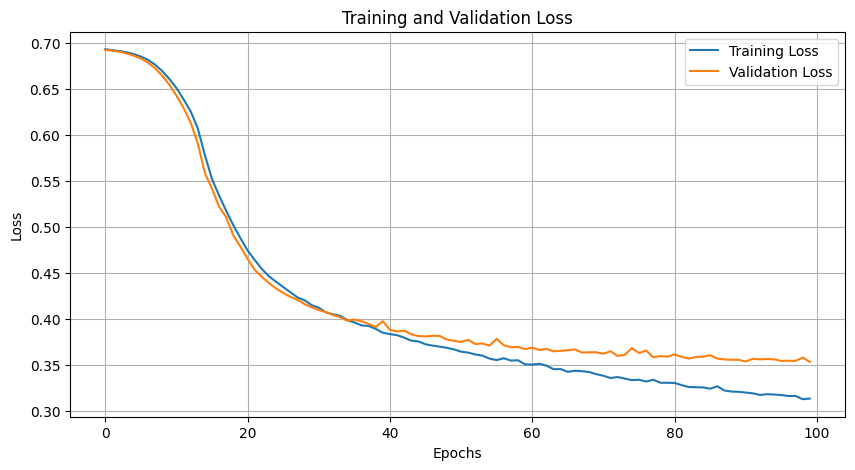

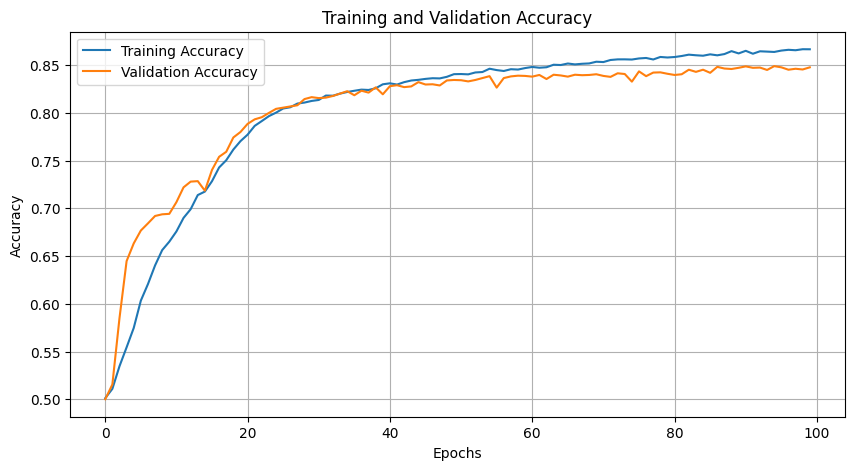

In [36]:

# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModifiedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.pool = nn.AdaptiveMaxPool1d(1)  # Global Max Pooling
        self.fc1 = nn.Linear(hidden_dim, 16)
        # self.bn1 = nn.BatchNorm1d(16)  # Batch normalization layer after fc1
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out.transpose(1, 2)  # Transpose for pooling
        pooled_out = self.pool(lstm_out).squeeze(-1)
        dropped_out = self.dropout(pooled_out)
        fc1_out = self.fc1(dropped_out)
        # bn1_out = self.bn1(fc1_out)  # Applying batch normalization
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.2
batch_size = 700
num_epochs = 100
learning_rate = 0.0001
weight_decay = 7e-4


# Instantiate the model and move to device
model = ModifiedLSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        # Playround with this 
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            # Playround with this
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### Training Loss: 0.3133, Validation Loss: 0.3533
#### Train Accuracy: 0.8667, Validation Accuracy: 0.8478, Test Accuracy: 0.8478
#### Compute Time: 48 seconds

# PREVIOUS ATTEMPTS

/tmp/ipykernel_5943/1591659742.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_5943/1591659742.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_5943/1591659742.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_5943/1591659742.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 1/85, Loss: 0.6893, Validation Loss: 0.6846, Train Accuracy: 0.5355, Validation Accuracy: 0.5585
Epoch 2/85, Loss: 0.6747, Validation Loss: 0.6702, Train Accuracy: 0.5833, Validation Accuracy: 0.6110
Epoch 3/85, Loss: 0.6583, Validation Loss: 0.6530, Train Accuracy: 0.6273, Validation Accuracy: 0.6428
Epoch 4/85, Loss: 0.6386, Validation Loss: 0.6326, Train Accuracy: 0.6619, Validation Accuracy: 0.6695
Epoch 5/85, Loss: 0.6173, Validation Loss: 0.6123, Train Accuracy: 0.6922, Validation Accuracy: 0.6925
Epoch 6/85, Loss: 0.5961, Validation Loss: 0.5924, Train Accuracy: 0.7151, Validation Accuracy: 0.7080
Epoch 7/85, Loss: 0.5753, Validation Loss: 0.5728, Train Accuracy: 0.7318, Validation Accuracy: 0.7205
Epoch 8/85, Loss: 0.5560, Validation Loss: 0.5554, Train Accuracy: 0.7454, Validation Accuracy: 0.7348
Epoch 9/85, Loss: 0.5381, Validation Loss: 0.5390, Train Accuracy: 0.7573, Validation Accuracy: 0.7430
Epoch 10/85, Loss: 0.5216, Validation Loss: 0.5254, Train Accuracy: 0.765

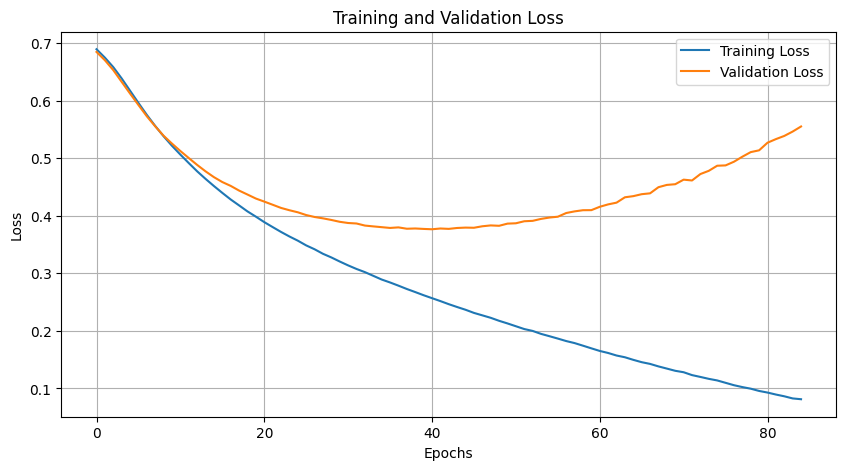

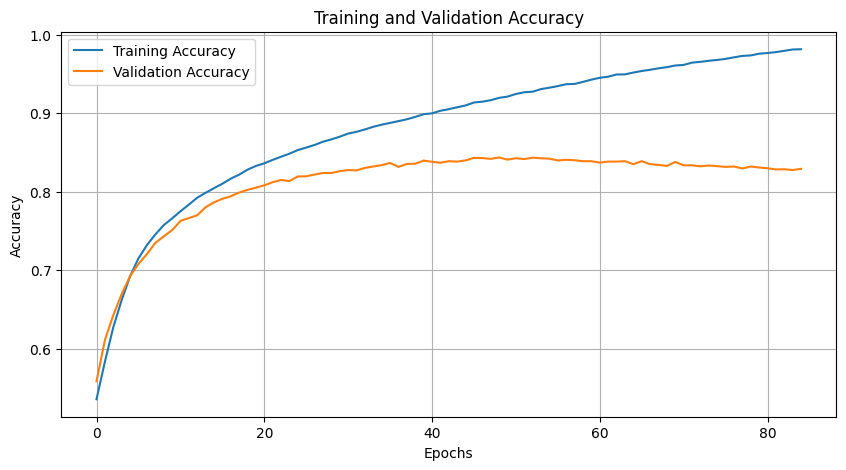

In [25]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModifiedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.pool = nn.AdaptiveMaxPool1d(1)  # Global Max Pooling
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.bn1 = nn.BatchNorm1d(16)  # Batch normalization layer after fc1
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out.transpose(1, 2)  # Transpose for pooling
        pooled_out = self.pool(lstm_out).squeeze(-1)
        dropped_out = self.dropout(pooled_out)
        fc1_out = self.fc1(dropped_out)
        bn1_out = self.bn1(fc1_out)  # Applying batch normalization
        relu_out = self.relu(bn1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0
batch_size = 512
num_epochs = 85
learning_rate = 0.00008
weight_decay = 5e-5


# Instantiate the model and move to device
model = ModifiedLSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_5943/3066320100.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_5943/3066320100.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_5943/3066320100.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_5943/3066320100.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 1/100, Loss: 0.6929, Validation Loss: 0.6912, Train Accuracy: 0.5109, Validation Accuracy: 0.5525
Epoch 2/100, Loss: 0.6909, Validation Loss: 0.6891, Train Accuracy: 0.5374, Validation Accuracy: 0.6048
Epoch 3/100, Loss: 0.6881, Validation Loss: 0.6863, Train Accuracy: 0.5696, Validation Accuracy: 0.6350
Epoch 4/100, Loss: 0.6850, Validation Loss: 0.6817, Train Accuracy: 0.5891, Validation Accuracy: 0.6655
Epoch 5/100, Loss: 0.6796, Validation Loss: 0.6752, Train Accuracy: 0.6143, Validation Accuracy: 0.6810
Epoch 6/100, Loss: 0.6724, Validation Loss: 0.6665, Train Accuracy: 0.6373, Validation Accuracy: 0.6953
Epoch 7/100, Loss: 0.6627, Validation Loss: 0.6548, Train Accuracy: 0.6556, Validation Accuracy: 0.7083
Epoch 8/100, Loss: 0.6506, Validation Loss: 0.6396, Train Accuracy: 0.6731, Validation Accuracy: 0.7167
Epoch 9/100, Loss: 0.6343, Validation Loss: 0.6177, Train Accuracy: 0.6852, Validation Accuracy: 0.7232
Epoch 10/100, Loss: 0.6033, Validation Loss: 0.5741, Train Accur

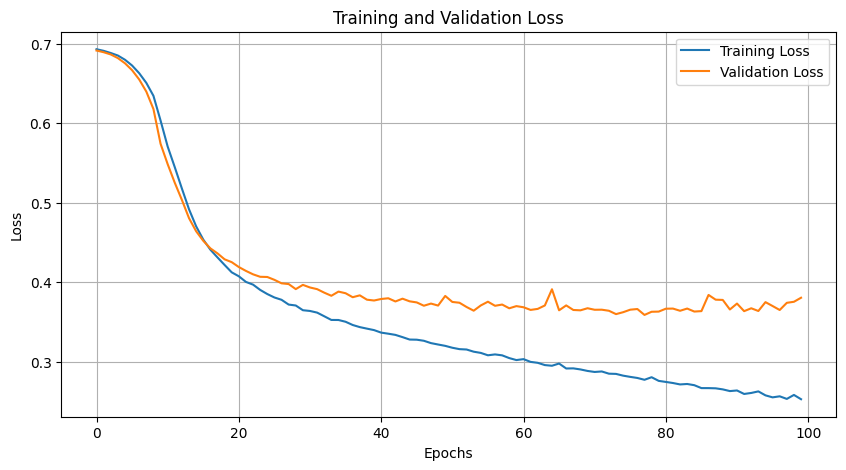

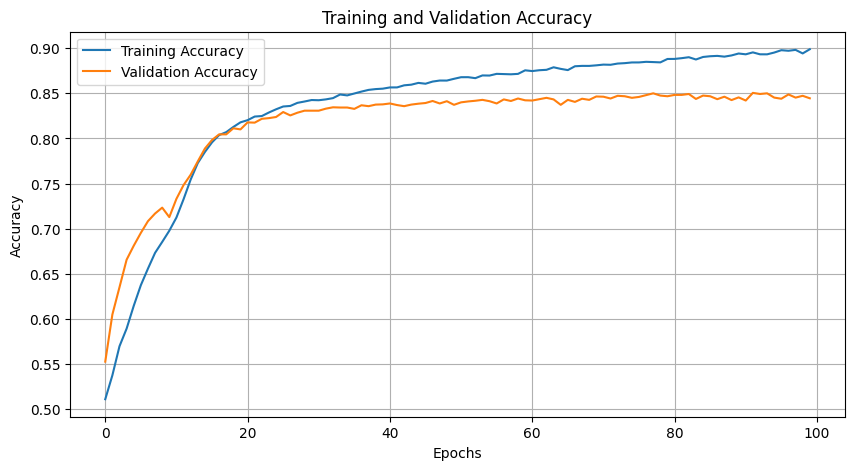

In [33]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModifiedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.pool = nn.AdaptiveMaxPool1d(1)  # Global Max Pooling
        self.fc1 = nn.Linear(hidden_dim, 16)
        # self.bn1 = nn.BatchNorm1d(16)  # Batch normalization layer after fc1
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out.transpose(1, 2)  # Transpose for pooling
        pooled_out = self.pool(lstm_out).squeeze(-1)
        dropped_out = self.dropout(pooled_out)
        fc1_out = self.fc1(dropped_out)
        # bn1_out = self.bn1(fc1_out)  # Applying batch normalization
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.2
batch_size = 512
num_epochs = 100
learning_rate = 0.0001
weight_decay = 3e-4


# Instantiate the model and move to device
model = ModifiedLSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        # Playround with this 
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            # Playround with this
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_5943/2653771389.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_5943/2653771389.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_5943/2653771389.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_5943/2653771389.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 1/100, Loss: 0.6934, Validation Loss: 0.6923, Train Accuracy: 0.5040, Validation Accuracy: 0.5345
Epoch 2/100, Loss: 0.6920, Validation Loss: 0.6913, Train Accuracy: 0.5265, Validation Accuracy: 0.5725
Epoch 3/100, Loss: 0.6908, Validation Loss: 0.6894, Train Accuracy: 0.5409, Validation Accuracy: 0.6120
Epoch 4/100, Loss: 0.6886, Validation Loss: 0.6870, Train Accuracy: 0.5653, Validation Accuracy: 0.6412
Epoch 5/100, Loss: 0.6858, Validation Loss: 0.6834, Train Accuracy: 0.5918, Validation Accuracy: 0.6508
Epoch 6/100, Loss: 0.6813, Validation Loss: 0.6785, Train Accuracy: 0.6200, Validation Accuracy: 0.6800
Epoch 7/100, Loss: 0.6757, Validation Loss: 0.6714, Train Accuracy: 0.6353, Validation Accuracy: 0.6940
Epoch 8/100, Loss: 0.6683, Validation Loss: 0.6625, Train Accuracy: 0.6485, Validation Accuracy: 0.6975
Epoch 9/100, Loss: 0.6577, Validation Loss: 0.6512, Train Accuracy: 0.6713, Validation Accuracy: 0.7093
Epoch 10/100, Loss: 0.6452, Validation Loss: 0.6373, Train Accur

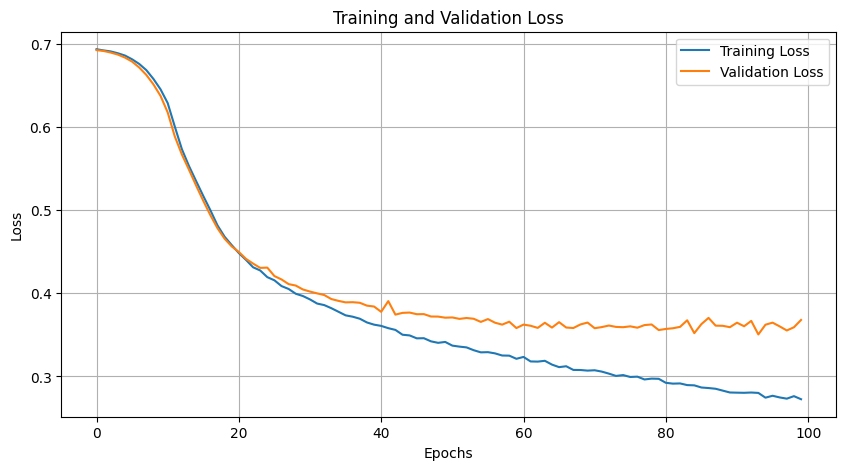

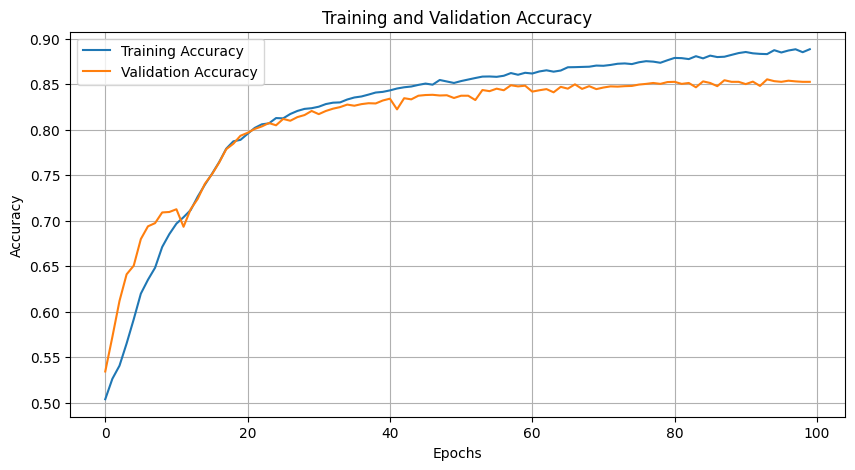

In [34]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModifiedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.pool = nn.AdaptiveMaxPool1d(1)  # Global Max Pooling
        self.fc1 = nn.Linear(hidden_dim, 16)
        # self.bn1 = nn.BatchNorm1d(16)  # Batch normalization layer after fc1
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out.transpose(1, 2)  # Transpose for pooling
        pooled_out = self.pool(lstm_out).squeeze(-1)
        dropped_out = self.dropout(pooled_out)
        fc1_out = self.fc1(dropped_out)
        # bn1_out = self.bn1(fc1_out)  # Applying batch normalization
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.2
batch_size = 700
num_epochs = 100
learning_rate = 0.0001
weight_decay = 3e-4


# Instantiate the model and move to device
model = ModifiedLSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        # Playround with this 
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            # Playround with this
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_5943/2215675378.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_5943/2215675378.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_5943/2215675378.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_5943/2215675378.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 1/100, Loss: 0.6931, Validation Loss: 0.6918, Train Accuracy: 0.5070, Validation Accuracy: 0.5383
Epoch 2/100, Loss: 0.6918, Validation Loss: 0.6904, Train Accuracy: 0.5245, Validation Accuracy: 0.5823
Epoch 3/100, Loss: 0.6903, Validation Loss: 0.6887, Train Accuracy: 0.5426, Validation Accuracy: 0.6168
Epoch 4/100, Loss: 0.6884, Validation Loss: 0.6864, Train Accuracy: 0.5616, Validation Accuracy: 0.6627
Epoch 5/100, Loss: 0.6856, Validation Loss: 0.6829, Train Accuracy: 0.5856, Validation Accuracy: 0.6757
Epoch 6/100, Loss: 0.6817, Validation Loss: 0.6779, Train Accuracy: 0.6053, Validation Accuracy: 0.6820
Epoch 7/100, Loss: 0.6761, Validation Loss: 0.6712, Train Accuracy: 0.6259, Validation Accuracy: 0.6787
Epoch 8/100, Loss: 0.6689, Validation Loss: 0.6628, Train Accuracy: 0.6436, Validation Accuracy: 0.6910
Epoch 9/100, Loss: 0.6598, Validation Loss: 0.6526, Train Accuracy: 0.6577, Validation Accuracy: 0.7040
Epoch 10/100, Loss: 0.6485, Validation Loss: 0.6405, Train Accur

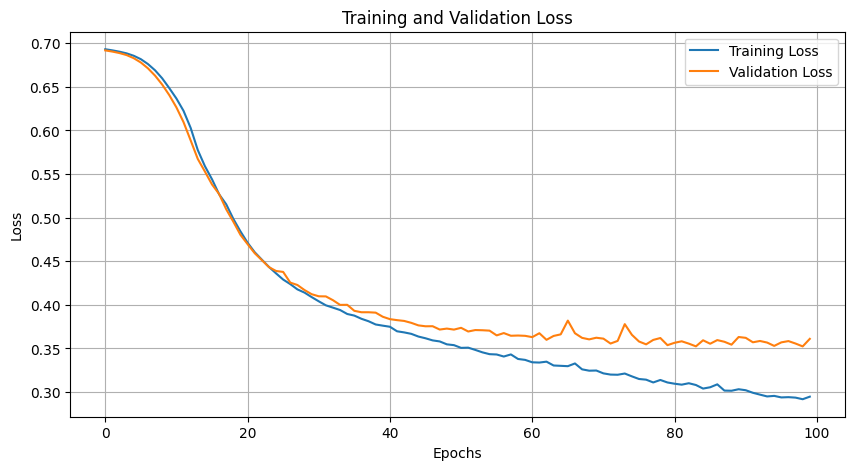

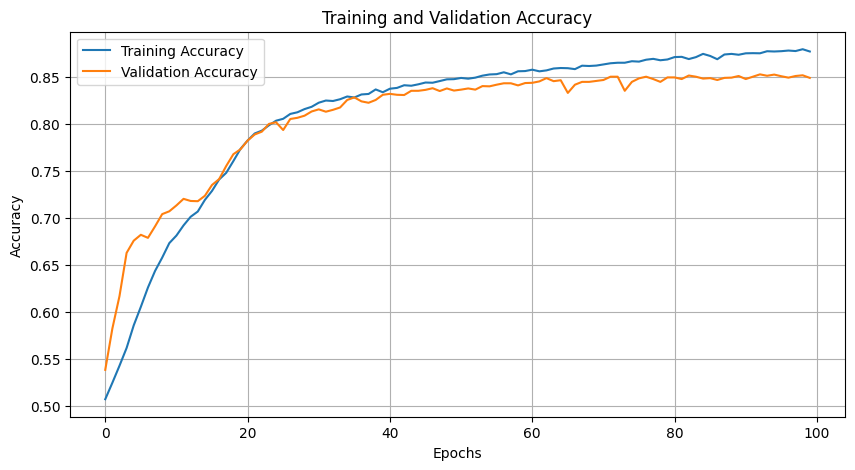

In [35]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModifiedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.pool = nn.AdaptiveMaxPool1d(1)  # Global Max Pooling
        self.fc1 = nn.Linear(hidden_dim, 16)
        # self.bn1 = nn.BatchNorm1d(16)  # Batch normalization layer after fc1
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out.transpose(1, 2)  # Transpose for pooling
        pooled_out = self.pool(lstm_out).squeeze(-1)
        dropped_out = self.dropout(pooled_out)
        fc1_out = self.fc1(dropped_out)
        # bn1_out = self.bn1(fc1_out)  # Applying batch normalization
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.2
batch_size = 700
num_epochs = 100
learning_rate = 0.0001
weight_decay = 5e-4


# Instantiate the model and move to device
model = ModifiedLSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        # Playround with this 
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            # Playround with this
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_5943/2180334005.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_5943/2180334005.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_5943/2180334005.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_5943/2180334005.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 1/100, Loss: 0.6978, Validation Loss: 0.6947, Train Accuracy: 0.5000, Validation Accuracy: 0.5000
Epoch 2/100, Loss: 0.6944, Validation Loss: 0.6933, Train Accuracy: 0.5005, Validation Accuracy: 0.5000
Epoch 3/100, Loss: 0.6932, Validation Loss: 0.6927, Train Accuracy: 0.5060, Validation Accuracy: 0.5095
Epoch 4/100, Loss: 0.6926, Validation Loss: 0.6923, Train Accuracy: 0.5144, Validation Accuracy: 0.5510
Epoch 5/100, Loss: 0.6921, Validation Loss: 0.6918, Train Accuracy: 0.5259, Validation Accuracy: 0.5660
Epoch 6/100, Loss: 0.6917, Validation Loss: 0.6909, Train Accuracy: 0.5319, Validation Accuracy: 0.5883
Epoch 7/100, Loss: 0.6906, Validation Loss: 0.6897, Train Accuracy: 0.5496, Validation Accuracy: 0.5935
Epoch 8/100, Loss: 0.6890, Validation Loss: 0.6877, Train Accuracy: 0.5648, Validation Accuracy: 0.6235
Epoch 9/100, Loss: 0.6867, Validation Loss: 0.6851, Train Accuracy: 0.5909, Validation Accuracy: 0.6400
Epoch 10/100, Loss: 0.6835, Validation Loss: 0.6815, Train Accur

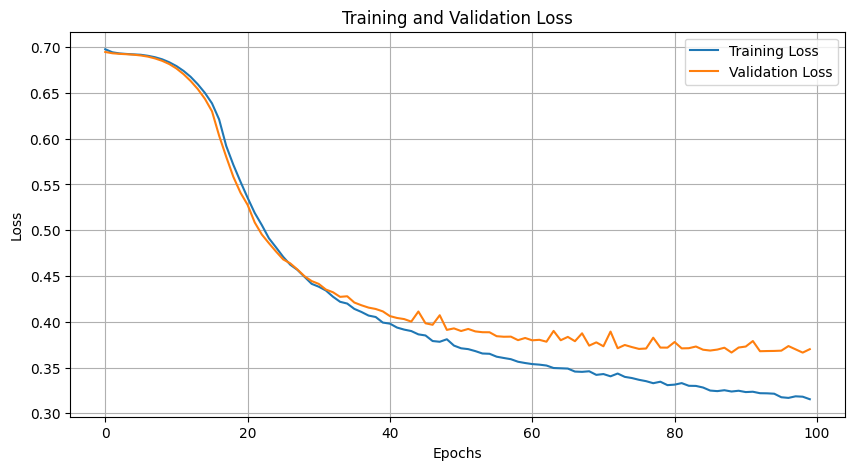

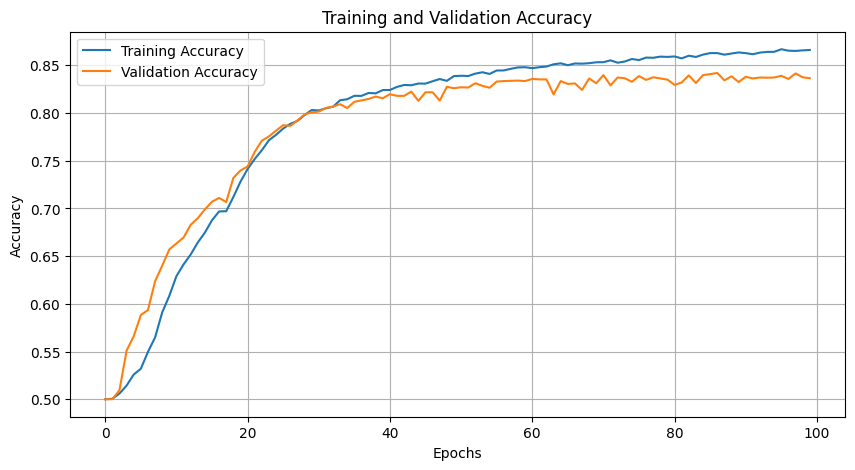

In [37]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(ModifiedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.pool = nn.AdaptiveMaxPool1d(1)  # Global Max Pooling
        self.fc1 = nn.Linear(hidden_dim, 16)
        # self.bn1 = nn.BatchNorm1d(16)  # Batch normalization layer after fc1
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out.transpose(1, 2)  # Transpose for pooling
        pooled_out = self.pool(lstm_out).squeeze(-1)
        dropped_out = self.dropout(pooled_out)
        fc1_out = self.fc1(dropped_out)
        # bn1_out = self.bn1(fc1_out)  # Applying batch normalization
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.2
batch_size = 700
num_epochs = 100
learning_rate = 0.0001
weight_decay = 9e-4


# Instantiate the model and move to device
model = ModifiedLSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        # Playround with this 
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Corrected loss calculation
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            # Playround with this
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))


# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()